In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plotting packs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLP packs
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from textblob import TextBlob , Word
import re 
import string

##Wordcloud Modules
from wordcloud import WordCloud , STOPWORDS

#Machine learning Packs
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [3]:
train=pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test=pd.read_csv('../input/contradictory-my-dear-watson/test.csv')

In [4]:
#train = train[train.lang_abv=='en']
#test = test[test.lang_abv=='en']
df = train.append(test)
df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0.0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2.0
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0.0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0.0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1.0
...,...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu,NaN
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English,NaN
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese,NaN
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English,NaN


In [5]:
df['text'] = df.apply(lambda x: x.premise + x.hypothesis, axis=1)

In [6]:
#df.loc[df.lang_abv !='en', 'text'] = df[df.lang_abv !='en'].apply(lambda x: str(TextBlob(x.text).translate(from_lang=x.lang_abv, to='en')), axis=1)
#HTTPError: HTTP Error 403: Forbidden hatasi veriyor

## Data Preparation

In [7]:
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

df['text'] = df['text'].apply(lambda x : word_tokenize(x.lower())) # cumle -> words
df["text"] = df["text"].apply(lambda x : [word for word in x if word not in STOPWORDS]) # stop words cikarma
df["text"] = df["text"].apply(lambda x : [SnowballStemmer("english").stem(word) for word in x]) # kelimelerin kok halleri
df["text"] = df["text"].apply(lambda x : " ".join(x)) # kelimleri birleştirdik
df["Polarity"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity) # ardindan countplot guzel olur
df["Subjectivity"] = df["text"].apply(lambda x : TextBlob(x).sentiment.subjectivity) # subjectivity hesaplama

<AxesSubplot:xlabel='Polarity', ylabel='Subjectivity'>

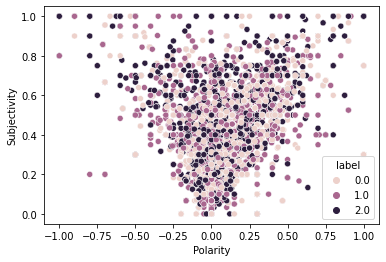

In [8]:
sns.scatterplot(x='Polarity', y='Subjectivity', hue='label', data=df[:train.shape[0]])

In [9]:
df_train = df[:train.shape[0]]
df_test = df[train.shape[0]:]

In [10]:
def nlp_analysis(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=4)
    
    vectorizers=[CountVectorizer(), TfidfVectorizer()]
    ngrams = [(1,1), (1,2)]
    
    classifiers=[LogisticRegression(), KNeighborsClassifier(3), DecisionTreeClassifier(), RandomForestClassifier(),
    AdaBoostClassifier(), GradientBoostingClassifier(), MultinomialNB(), BernoulliNB(), XGBClassifier()]
    
    col_names = ['Classifier','Methods', 'N-Grams','Accuracy','Precision','Recall', 'F1']
    df_nlp = pd.DataFrame(columns=col_names)   

    for i in vectorizers:
        vec=i
        vec_name = i.__class__.__name__
        vec.stop_words='english'
        vec.min_df=0.005
        
        for j in ngrams:
            vec.ngram_range=j
            X_train_dtm = vec.fit_transform(X_train)
            X_test_dtm = vec.transform(X_test)
            
            for k in classifiers:
                pred = k.fit(X_train_dtm, y_train).predict(X_test_dtm)
                clas_name = k.__class__.__name__
                
                accuracy = accuracy_score(y_test, pred)
                precision = precision_score(y_test, pred, average='weighted')
                f1 = f1_score(y_test, pred, average='weighted')
                recall = recall_score(y_test, pred, average='weighted')
                
                df_entry = pd.DataFrame([[clas_name, vec_name, j, accuracy*100, precision*100, recall*100, f1*100]], 
                                        columns=col_names)
                df_nlp=df_nlp.append(df_entry)
    return df_nlp

In [11]:
nlp_analysis(df_train.text, df_train.label).sort_values(by='Accuracy', ascending=False)

,Classifier,Methods,N-Grams,Accuracy,Precision,Recall,F1
0,GradientBoostingClassifier,CountVectorizer,"(1, 1)",35.066007,34.346037,35.066007,30.498391
0,AdaBoostClassifier,TfidfVectorizer,"(1, 1)",34.900990,34.094646,34.900990,28.608777
0,XGBClassifier,CountVectorizer,"(1, 2)",34.900990,34.253558,34.900990,33.140765
0,AdaBoostClassifier,CountVectorizer,"(1, 1)",34.818482,34.459846,34.818482,30.557879
0,AdaBoostClassifier,CountVectorizer,"(1, 2)",34.818482,34.459846,34.818482,30.557879
0,GradientBoostingClassifier,CountVectorizer,"(1, 2)",34.570957,33.163645,34.570957,29.553090
0,AdaBoostClassifier,TfidfVectorizer,"(1, 2)",34.570957,33.551047,34.570957,28.338968
0,GradientBoostingClassifier,TfidfVectorizer,"(1, 1)",34.405941,33.165180,34.405941,30.141163
0,GradientBoostingClassifier,TfidfVectorizer,"(1, 2)",34.158416,33.014784,34.158416,30.243247
0,MultinomialNB,TfidfVectorizer,"(1, 2)",33.993399,33.894850,33.993399,32.602801


## Prediction

In [12]:
cv = CountVectorizer(min_df=0.005, ngram_range=(1,2), stop_words='english')
train_dtm=cv.fit_transform(df_train.text)
test_dtm=cv.transform(df_test.text) # labelsiz

In [13]:
gbc=GradientBoostingClassifier()
gbc.fit(train_dtm, df_train.label)
pred=gbc.predict(test_dtm)
pred

array([2., 2., 1., ..., 0., 1., 0.])

In [14]:
submission=pd.DataFrame()
submission['id']=df_test.id
submission['prediction'] = pred.astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,2
2,e98005252c,1
3,58518c10ba,0
4,c32b0d16df,0


In [15]:
np.array([1., 2., 3.]).astype(int)

array([1, 2, 3])